In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from geopy.distance import geodesic
import time
from IPython.display import clear_output

sns.set()

In [2]:
df = pd.read_csv('/content/drive/MyDrive/taxi_trip_data (1).csv')


In [4]:
df.shape

(10000000, 17)

In [3]:
with_dups = df.shape[0]
df.drop_duplicates(inplace=True)

print(f"{round((with_dups - df.shape[0]) / with_dups * 100, 2)}% of rows were duplicates")
print(f"Duplicates dropped with {df.shape[0]} rows remaining")

6.08% of rows were duplicates
Duplicates dropped with 9392429 rows remaining


In [6]:
df.isna().sum()

vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
trip_distance          0
rate_code              0
store_and_fwd_flag     0
payment_type           0
fare_amount            0
extra                  0
mta_tax                0
tip_amount             0
tolls_amount           0
imp_surcharge          0
total_amount           0
pickup_location_id     0
dropoff_location_id    0
dtype: int64

In [5]:
def zero_cnt(df):
    print("Count of zeroes and empty strings:")
    print("column                   count     percentage")
    for col in df.columns:
        if df[col].dtype != 'object':
            cnt = df[df[col] == 0].shape[0]
        else:
            cnt = df[df[col] == ''].shape[0]
        print(f"{col:<25}{cnt:<10}{round(cnt/df.shape[0]*100, 2):<5}")

zero_cnt(df)

Count of zeroes and empty strings:
column                   count     percentage
vendor_id                0         0.0  
pickup_datetime          0         0.0  
dropoff_datetime         0         0.0  
passenger_count          0         0.0  
trip_distance            0         0.0  
rate_code                0         0.0  
store_and_fwd_flag       0         0.0  
payment_type             0         0.0  
fare_amount              0         0.0  
extra                    4801203   53.1 
mta_tax                  214307    2.37 
tip_amount               1891064   20.92
tolls_amount             5948376   65.79
imp_surcharge            1410      0.02 
total_amount             0         0.0  
pickup_location_id       0         0.0  
dropoff_location_id      0         0.0  


In [6]:
df = df[df['trip_distance'] != 0]
df = df[df['fare_amount'] != 0]
df = df[df['passenger_count'] != 0]

# Call zero_cnt function to count occurrences of zero values and empty strings in each column
zero_cnt(df)


Count of zeroes and empty strings:
column                   count     percentage
vendor_id                0         0.0  
pickup_datetime          0         0.0  
dropoff_datetime         0         0.0  
passenger_count          0         0.0  
trip_distance            0         0.0  
rate_code                0         0.0  
store_and_fwd_flag       0         0.0  
payment_type             0         0.0  
fare_amount              0         0.0  
extra                    4801203   53.1 
mta_tax                  214307    2.37 
tip_amount               1891064   20.92
tolls_amount             5948376   65.79
imp_surcharge            1410      0.02 
total_amount             0         0.0  
pickup_location_id       0         0.0  
dropoff_location_id      0         0.0  


In [7]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [8]:
df['weekday'] = df.pickup_datetime.dt.day_name()
df['month'] = df.pickup_datetime.dt.month
df['weekday_num'] = df.pickup_datetime.dt.weekday
df['pickup_hour'] = df.pickup_datetime.dt.hour

In [9]:
# Calculate trip durations

df['trip_duration'] = df['dropoff_datetime'] - df['pickup_datetime']


df['trip_duration_seconds'] = df['trip_duration'].dt.total_seconds()

In [10]:
df = df[df['vendor_id'] != 4]

In [11]:
pd.options.display.float_format = '{:.2f}'.format


In [12]:
negative_trip_distances = df[df['trip_distance'] < 0]

# Count the number of negative values
num_negative_trip_distances = negative_trip_distances.shape[0]

# Print the number of negative values
print("Number of negative trip distances:", num_negative_trip_distances)


Number of negative trip distances: 0


In [15]:
# Check for negative values in the 'trip_duration_seconds' column
negative_trip_durations = df[df['trip_duration_seconds'] < 0]

# Count the number of negative values
num_negative_trip_durations = negative_trip_durations.shape[0]

# Print the number of negative values
print("Number of negative trip durations:", num_negative_trip_durations)


Number of negative trip durations: 129


In [13]:
# Remove rows with negative trip durations
df = df[df['trip_duration_seconds'] >= 0]

# Verify the removal by checking the number of negative trip durations
num_negative_trip_durations_after_removal = df[df['trip_duration_seconds'] < 0].shape[0]

# Print the number of negative trip durations after removal (should be 0)
print("Number of negative trip durations after removal:", num_negative_trip_durations_after_removal)


Number of negative trip durations after removal: 0


In [14]:
# List of columns to check
columns_to_check = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge', 'total_amount']

# Check for negative values in each column
for column in columns_to_check:
    negative_values = df[df[column] < 0]
    num_negative_values = negative_values.shape[0]
    print(f"Number of negative values in '{column}' column: {num_negative_values}")


Number of negative values in 'fare_amount' column: 22401
Number of negative values in 'extra' column: 11724
Number of negative values in 'mta_tax' column: 22122
Number of negative values in 'tip_amount' column: 294
Number of negative values in 'tolls_amount' column: 186
Number of negative values in 'imp_surcharge' column: 22398
Number of negative values in 'total_amount' column: 22401


In [15]:
# List of columns with negative values
columns_with_negative_values = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge', 'total_amount']

# Create a boolean mask for rows with any negative values in these columns
negative_mask = df[columns_with_negative_values].lt(0).any(axis=1)

# Remove rows with any negative values
df_cleaned = df[~negative_mask]

# Print the number of rows removed
num_rows_removed = sum(negative_mask)
print("Number of rows removed:", num_rows_removed)


Number of rows removed: 22412


In [16]:
df.shape

(8996881, 23)

In [17]:
# Select float and integer columns
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Check if any numeric column has negative values
negative_values = numeric_columns.lt(0).any()

# Print columns with negative values
print("Numeric columns with negative values:")
print(negative_values[negative_values].index.tolist())



Numeric columns with negative values:
['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge', 'total_amount']


In [18]:
# Define the numeric columns with negative values
numeric_cols = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge', 'total_amount']

# Remove rows with negative values in specific numeric columns
df = df[(df[numeric_cols] >= 0).all(axis=1)]


In [19]:
# Select float and integer columns
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Check if any numeric column has negative values
negative_values = numeric_columns.lt(0).any()

# Print columns with negative values
print("Numeric columns with negative values:")
print(negative_values[negative_values].index.tolist())

Numeric columns with negative values:
[]


In [20]:
df.loc[:, 'speed'] = df['trip_distance'] / (df['trip_duration_seconds'] / 3600)


In [21]:
# Check for negative values in the 'speed' column
negative_speed = df[df['speed'] < 0]

# Check for values above 150 in the 'speed' column
high_speed = df[df['speed'] > 150]

# Display the rows where 'speed' is negative
print("Rows with negative speed:")
print(negative_speed)

# Display the rows where 'speed' is above 150
print("\nRows with speed above 150:")
print(high_speed)


Rows with negative speed:
Empty DataFrame
Columns: [vendor_id, pickup_datetime, dropoff_datetime, passenger_count, trip_distance, rate_code, store_and_fwd_flag, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, imp_surcharge, total_amount, pickup_location_id, dropoff_location_id, weekday, month, weekday_num, pickup_hour, trip_duration, trip_duration_seconds, speed]
Index: []

[0 rows x 24 columns]

Rows with speed above 150:
         vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
154              1 2018-08-03 19:57:29 2018-08-03 19:57:30                1   
374              1 2018-07-23 17:50:26 2018-07-23 17:50:52                1   
1006             1 2018-09-17 15:34:41 2018-09-17 15:34:54                1   
1061             1 2018-03-12 16:34:21 2018-03-12 16:34:31                1   
2346             2 2018-12-15 23:17:27 2018-12-15 23:17:30                1   
...            ...                 ...                 ...              ...   

In [22]:
# Remove rows with speed above 150
df = df[df['speed'] <= 150]


In [23]:
less_than_1_mile = df[df['trip_distance'] < 1]
num_rows = less_than_1_mile.shape[0]
print("Number of rows with trip distance less than 1 mile:", num_rows)

Number of rows with trip distance less than 1 mile: 338543


In [24]:
df.drop(less_than_1_mile.index, inplace=True)


In [35]:
df.dtypes

vendor_id                          int64
pickup_datetime           datetime64[ns]
dropoff_datetime          datetime64[ns]
passenger_count                    int64
trip_distance                    float64
rate_code                          int64
store_and_fwd_flag                object
payment_type                       int64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
imp_surcharge                    float64
total_amount                     float64
pickup_location_id                 int64
dropoff_location_id                int64
weekday                           object
month                              int64
weekday_num                        int64
pickup_hour                        int64
trip_duration            timedelta64[ns]
trip_duration_seconds            float64
speed                            float64
dtype: object

In [25]:
num_rows_equal_total_fare = len(df[df['total_amount'] == df['fare_amount'] + df['extra'] + df['mta_tax'] + df['tip_amount'] + df['tolls_amount'] + df['imp_surcharge']])
print("Number of rows where total amount equals sum of fare components:", num_rows_equal_total_fare)


Number of rows where total amount equals sum of fare components: 5646201


In [26]:
# Keep only the rows where total amount equals sum of fare components
df = df[df['total_amount'] == df['fare_amount'] + df['extra'] + df['mta_tax'] + df['tip_amount'] + df['tolls_amount'] + df['imp_surcharge']]


In [27]:
df.shape

(5646201, 24)

In [40]:
df.describe

<bound method NDFrame.describe of          vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0                2 2018-03-29 13:37:13 2018-03-29 14:17:01                1   
1                2 2018-03-29 13:37:18 2018-03-29 14:15:33                1   
6                1 2018-03-29 14:09:41 2018-03-29 14:36:29                1   
7                2 2018-03-29 15:21:42 2018-03-29 16:04:16                1   
8                2 2018-03-29 15:14:59 2018-03-29 16:42:46                1   
...            ...                 ...                 ...              ...   
9999980          1 2018-06-19 16:11:42 2018-06-19 16:41:52                1   
9999983          1 2018-06-19 18:10:32 2018-06-19 18:41:58                1   
9999984          2 2018-06-19 20:14:05 2018-06-19 20:34:49                5   
9999985          1 2018-06-19 21:11:43 2018-06-19 21:39:34                1   
9999986          1 2018-06-19 21:54:36 2018-06-19 22:18:08                2   

         trip_dis

In [41]:
df.dtypes

vendor_id                          int64
pickup_datetime           datetime64[ns]
dropoff_datetime          datetime64[ns]
passenger_count                    int64
trip_distance                    float64
rate_code                          int64
store_and_fwd_flag                object
payment_type                       int64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
imp_surcharge                    float64
total_amount                     float64
pickup_location_id                 int64
dropoff_location_id                int64
weekday                           object
month                              int64
weekday_num                        int64
pickup_hour                        int64
trip_duration            timedelta64[ns]
trip_duration_seconds            float64
speed                            float64
dtype: object

<ipython-input-42-c7af1682aa08>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot= True);


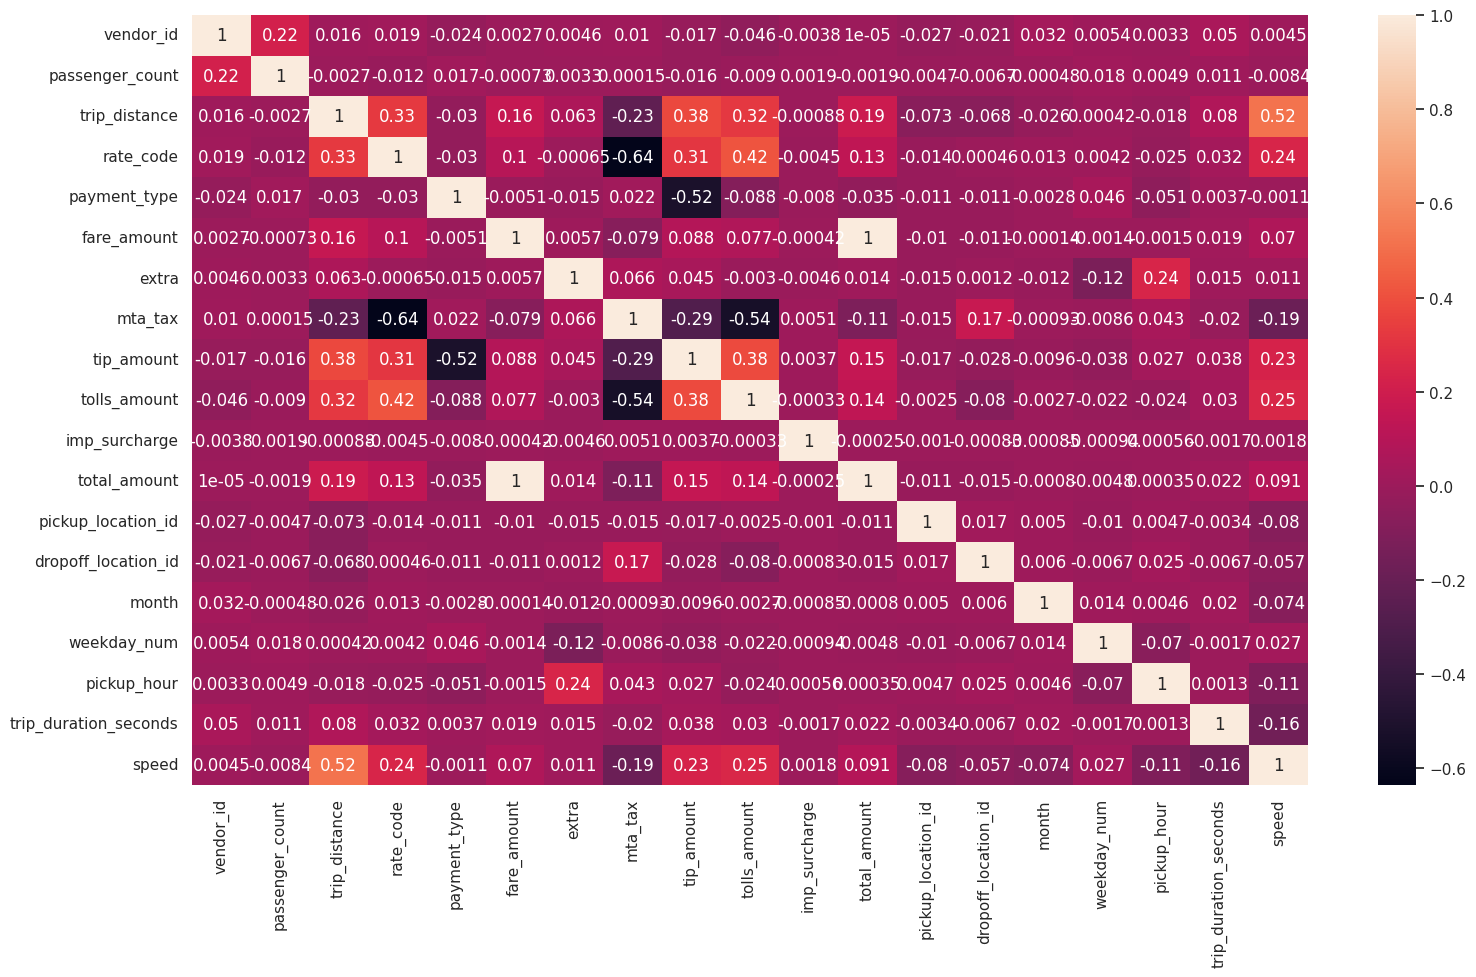

In [42]:
plt.figure(figsize= (18, 10))
sns.heatmap(df.corr(), annot= True);

In [43]:
df.head

<bound method NDFrame.head of          vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0                2 2018-03-29 13:37:13 2018-03-29 14:17:01                1   
1                2 2018-03-29 13:37:18 2018-03-29 14:15:33                1   
6                1 2018-03-29 14:09:41 2018-03-29 14:36:29                1   
7                2 2018-03-29 15:21:42 2018-03-29 16:04:16                1   
8                2 2018-03-29 15:14:59 2018-03-29 16:42:46                1   
...            ...                 ...                 ...              ...   
9999980          1 2018-06-19 16:11:42 2018-06-19 16:41:52                1   
9999983          1 2018-06-19 18:10:32 2018-06-19 18:41:58                1   
9999984          2 2018-06-19 20:14:05 2018-06-19 20:34:49                5   
9999985          1 2018-06-19 21:11:43 2018-06-19 21:39:34                1   
9999986          1 2018-06-19 21:54:36 2018-06-19 22:18:08                2   

         trip_distanc

In [28]:
x = df[['vendor_id', 'passenger_count', 'trip_distance','speed', 'pickup_location_id', 'dropoff_location_id', 'month', 'weekday_num', 'pickup_hour']]
y = df['trip_duration_seconds']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state = 8000)

In [45]:
from scipy.stats import pearsonr

# Convert y_train to a numpy array
y_train_array = y_train.to_numpy().reshape(len(y_train), 1)

# Concatenate x_train and y_train_array along axis 1
df1 = pd.DataFrame(np.concatenate((x_train, y_train_array), axis=1))

# Rename columns of df1
df1.columns = df1.columns.astype(str)

# List of features
features = df1.iloc[:, :8].columns.tolist()

# Target variable name
target = df1.iloc[:, 8].name

# Dictionary to store correlations
correlations = {}

# Calculate Pearson correlation coefficient for each feature
for f in features:
    data_temp = df1[[f, target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1, x2)[0]

# Create DataFrame to display correlations
data_correlations = pd.DataFrame(correlations, index=['Value']).T

# Sort correlations based on absolute values
sorted_correlations = data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

sorted_correlations


,Value
3 vs 8,-0.11
7 vs 8,-0.07
5 vs 8,0.03
2 vs 8,-0.02
1 vs 8,0.01
4 vs 8,0.00
6 vs 8,0.00
0 vs 8,0.00


In [47]:
df1.dtypes

0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
7    float64
8    float64
9    float64
dtype: object

In [46]:
df1.head

<bound method NDFrame.head of            0    1     2     3      4      5     6    7     8       9
0       1.00 1.00 10.80 14.85 161.00 138.00  5.00 4.00 13.00 2619.00
1       2.00 6.00  5.49  9.06 142.00 244.00 11.00 4.00  0.00 2182.00
2       2.00 2.00  7.68 17.33  79.00 168.00  7.00 5.00  2.00 1595.00
3       2.00 2.00  5.70 14.29  87.00 162.00 11.00 0.00 17.00 1436.00
4       2.00 1.00 17.27 27.03 132.00 229.00 12.00 3.00 18.00 2300.00
...      ...  ...   ...   ...    ...    ...   ...  ...   ...     ...
4516955 2.00 1.00  7.74 17.84 237.00  37.00  4.00 0.00 23.00 1562.00
4516956 2.00 1.00 13.54 15.12 239.00 180.00 11.00 6.00 12.00 3224.00
4516957 2.00 1.00  6.57 11.68  88.00  48.00 10.00 2.00 14.00 2025.00
4516958 2.00 1.00 16.72 24.47 137.00  51.00  6.00 1.00  9.00 2460.00
4516959 1.00 1.00 20.00 26.18 141.00 132.00  2.00 6.00 14.00 2750.00

[4516960 rows x 10 columns]>

In [35]:
df1.drop(columns=['6', '7'], inplace=True)


In [36]:
df1.head

<bound method NDFrame.head of            0    1     2      3      4     5       8
0       2.00 3.00  7.81  68.00 227.00  9.00 2000.00
1       2.00 2.00  4.97 238.00 158.00  3.00 1688.00
2       1.00 1.00 12.70 138.00  87.00  4.00 2551.00
3       1.00 1.00 26.20 138.00 138.00  8.00 5157.00
4       2.00 1.00 12.92 138.00  50.00  5.00 2637.00
...      ...  ...   ...    ...    ...   ...     ...
7261844 2.00 5.00  9.49 138.00 224.00  9.00 1575.00
7261845 1.00 1.00 11.80  79.00 138.00  8.00 1574.00
7261846 1.00 1.00  8.90 137.00 138.00  1.00 1151.00
7261847 1.00 1.00 18.10 132.00 230.00  3.00 3435.00
7261848 1.00 2.00 27.90 231.00  10.00 12.00 3093.00

[7261849 rows x 7 columns]>

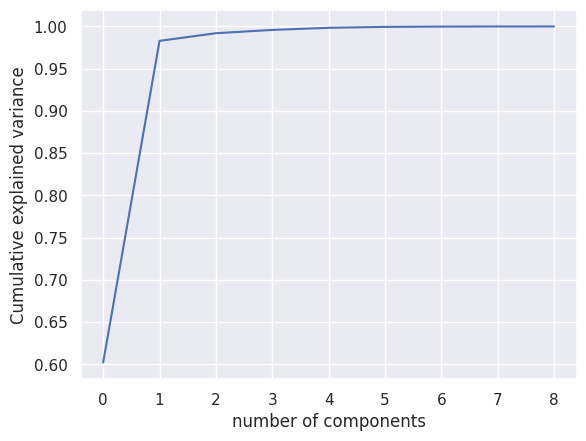

In [48]:
from sklearn.decomposition import PCA
pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [49]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 60.209999999999994),
 (2, 98.28999999999999),
 (3, 99.19999999999999),
 (4, 99.58999999999999),
 (5, 99.83999999999999),
 (6, 99.94999999999999),
 (7, 99.97999999999999),
 (8, 99.99)]

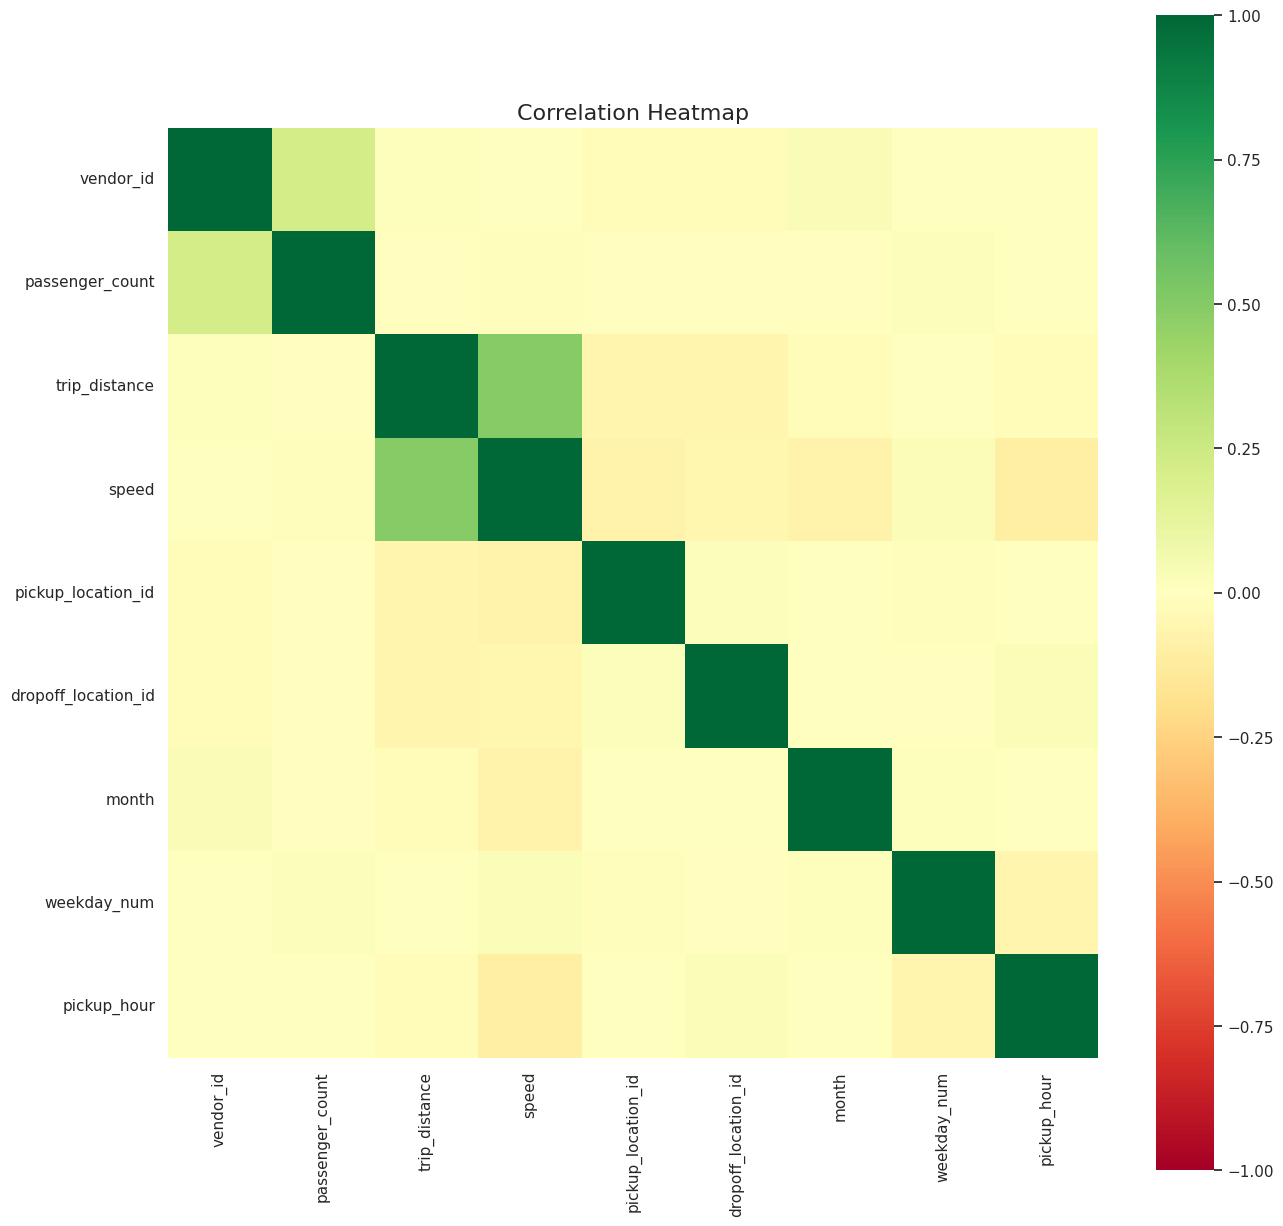

In [51]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(x_train).corr()
corr.index = pd.DataFrame(x_train).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()


In [52]:
#Multiple Linear Regression
start_time = time.time()
lm_regression = LinearRegression()
lm_regression = lm_regression.fit(x_train, y_train)
end_time = time.time()
lm_time = (end_time - start_time)
print(f"Time taken to train linear regression model : {lm_time} seconds")

Time taken to train linear regression model : 3.577615976333618 seconds


In [53]:
trips = lm_regression.predict(x_test)

In [56]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': trips})


In [57]:
predictions


,Actual,Predicted
9756074,2095.00,2355.15
9852514,2248.00,3176.04
9177885,2354.00,2066.61
8683963,4482.00,3449.47
488066,2373.00,2475.21
...,...,...
2396267,1843.00,1829.50
7550879,2732.00,3350.33
4042430,2929.00,3239.99
8540116,1357.00,1802.13


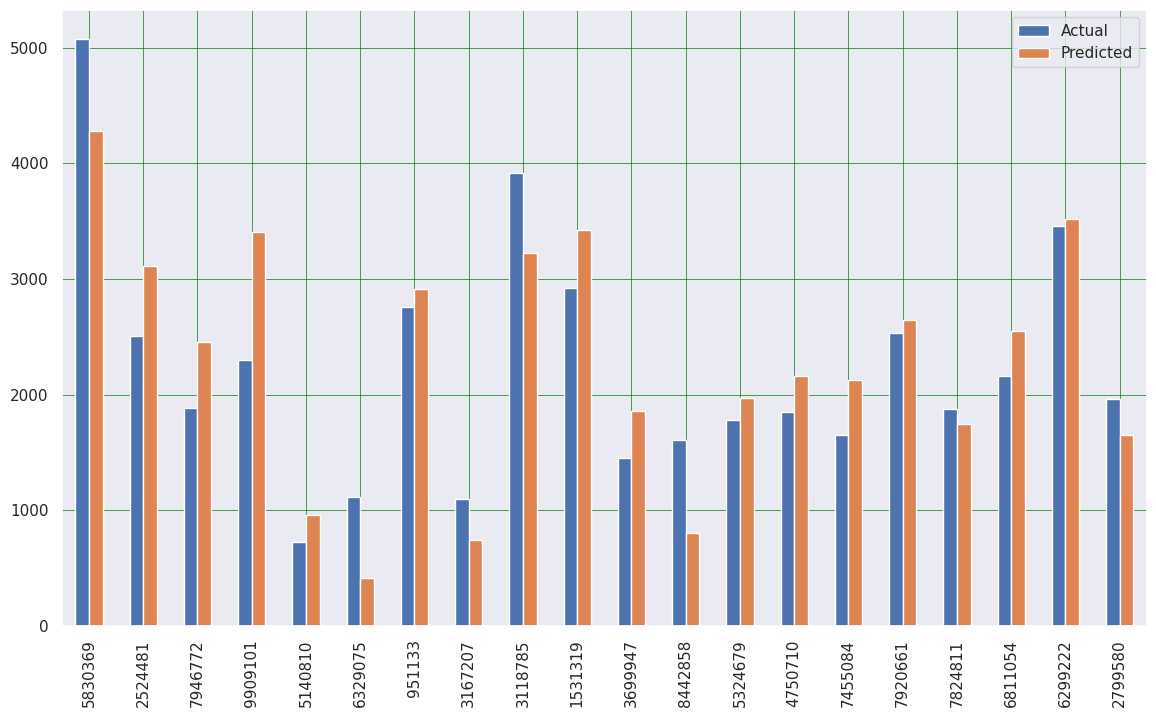

In [58]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [59]:
lm_score = r2_score(y_test, trips)
print(lm_score)

0.07023168670029833


In [60]:
#Decision Tree
start_time = time.time()
dt_regression = DecisionTreeRegressor()
dt_regression = dt_regression.fit(x_train, y_train)
end_time = time.time()
dt_time = (end_time - start_time)
print(f"Time taken to train Decision tree model : {dt_time} seconds")

Time taken to train Decision tree model : 65.64990019798279 seconds


In [61]:
trips = dt_regression.predict(x_test)

In [63]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': trips})


In [64]:
predictions


,Actual,Predicted
9756074,2095.00,2091.00
9852514,2248.00,2251.00
9177885,2354.00,2354.00
8683963,4482.00,4475.00
488066,2373.00,2373.00
...,...,...
2396267,1843.00,1843.00
7550879,2732.00,2733.00
4042430,2929.00,2928.00
8540116,1357.00,1357.00


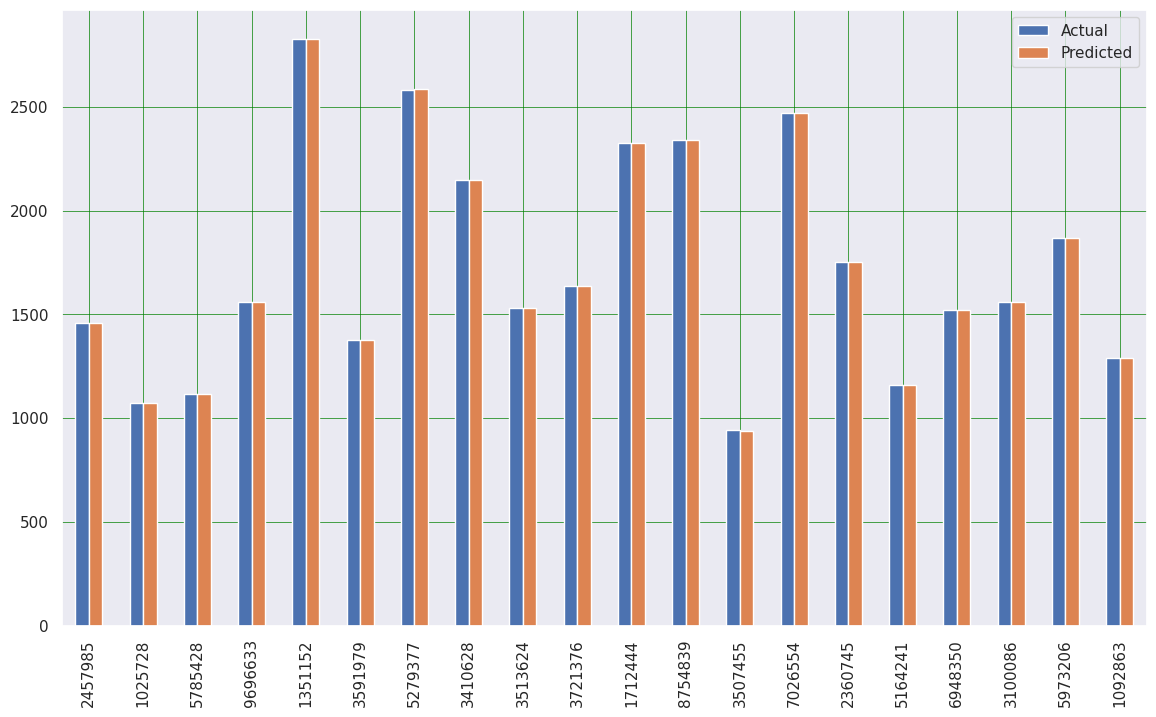

In [65]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [66]:
dt_score = r2_score(y_test, trips)
print(dt_score)

0.999457917115067


In [1]:
start_time = time.time()
rf_regression = RandomForestRegressor()
rf_regression = rf_regression.fit(x_train, y_train)
end_time = time.time()
rf_time = (end_time - start_time)
print(f"Time taken to train Random Forest model : {rf_time} seconds")

NameError: name 'time' is not defined

In [ ]:
trips = rf_regression.predict(x_test)


In [ ]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': trips})


In [ ]:
predictions

In [ ]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


In [ ]:
rf_score = r2_score(y_test, trips)
print(rf_score)

In [29]:
start_time = time.time()
regression = AdaBoostRegressor()
regression = regression.fit(x_train, y_train)
end_time = time.time()
ad_time = (end_time - start_time)
print(f"Time taken to train AdaBoost model : {ad_time} seconds")

Time taken to train AdaBoost model : 519.8957600593567 seconds


In [30]:
trips = regression.predict(x_test)

In [31]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': trips})


In [32]:
predictions

,Actual,Predicted
9756074,2095.00,2451.52
9852514,2248.00,2451.52
9177885,2354.00,2672.14
8683963,4482.00,2451.52
488066,2373.00,2451.52
...,...,...
2396267,1843.00,2451.52
7550879,2732.00,2451.52
4042430,2929.00,2672.14
8540116,1357.00,2451.52


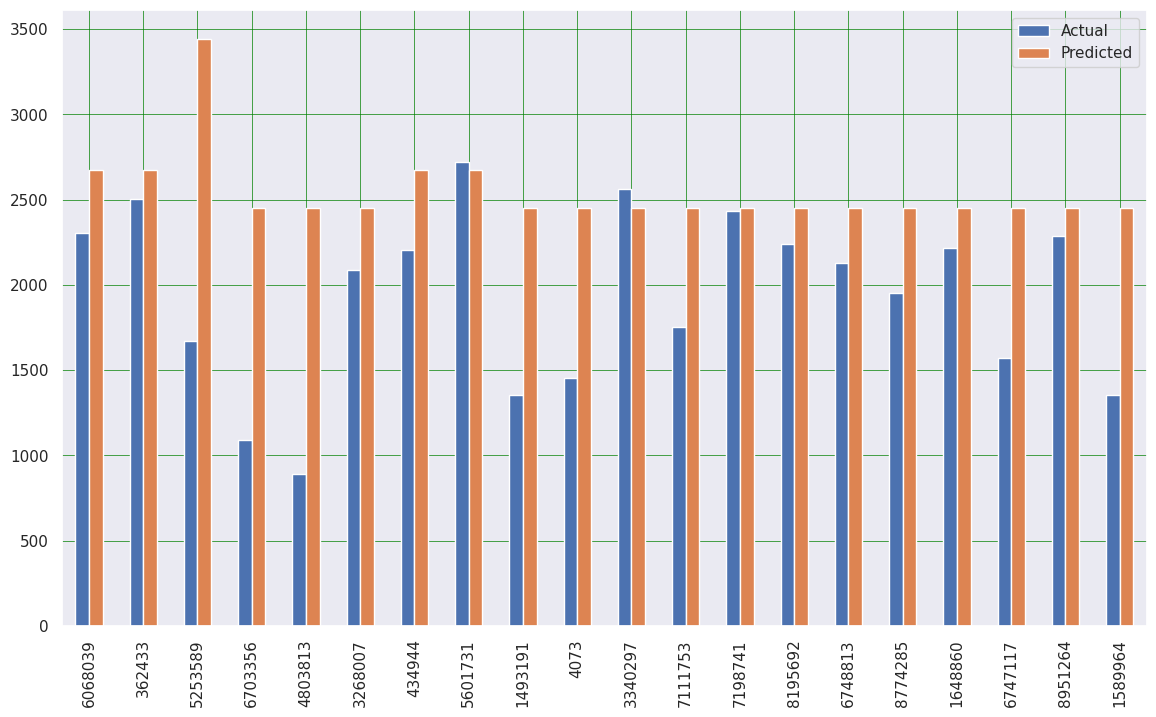

In [33]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [34]:
ad_score = r2_score(y_test, trips)
print(ad_score)

0.9179418318987103


In [35]:
start_time = time.time()
regression = GradientBoostingRegressor()
regression = regression.fit(x_train, y_train)
end_time = time.time()
gd_time = (end_time - start_time)
print(f"Time taken to train Gradient Boost model : {gd_time} seconds")

Time taken to train Gradient Boost model : 1228.4914560317993 seconds


In [36]:
trips = regression.predict(x_test)


In [37]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': trips})


In [38]:
predictions

,Actual,Predicted
9756074,2095.00,1979.13
9852514,2248.00,2205.44
9177885,2354.00,2307.30
8683963,4482.00,4350.99
488066,2373.00,2214.11
...,...,...
2396267,1843.00,1736.68
7550879,2732.00,2633.10
4042430,2929.00,2855.65
8540116,1357.00,1437.18


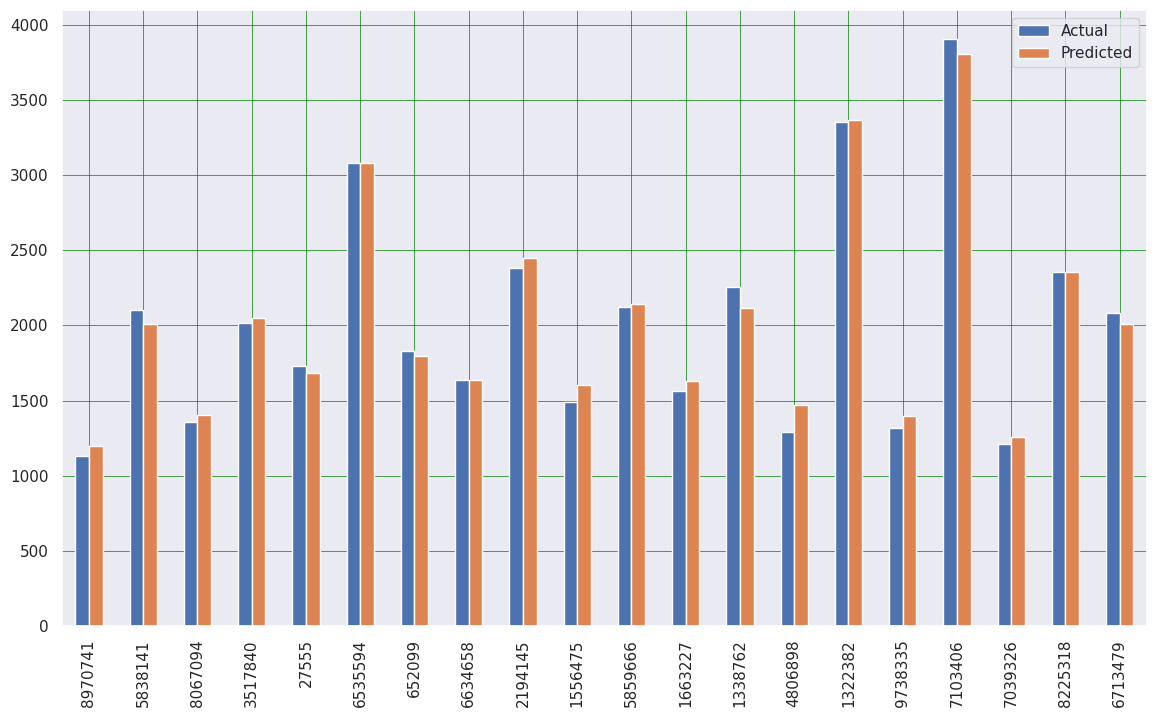

In [39]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [40]:
gd_score = r2_score(y_test, trips)
print(gd_score)

0.9964221476853856


In [41]:
start_time = time.time()
regression = XGBRegressor(objective ='reg:squarederror')
regression = regression.fit(x_train, y_train)
end_time = time.time()
xgb_time = (end_time - start_time)
print(f"Time taken to train XGBoost  model : {xgb_time} seconds")

Time taken to train XGBoost  model : 38.65097904205322 seconds


In [42]:
trips = regression.predict(x_test)


In [43]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': trips})


In [44]:
predictions

,Actual,Predicted
9756074,2095.00,2131.48
9852514,2248.00,2196.75
9177885,2354.00,2319.95
8683963,4482.00,4530.28
488066,2373.00,2399.95
...,...,...
2396267,1843.00,1814.17
7550879,2732.00,2751.48
4042430,2929.00,2856.94
8540116,1357.00,1370.86


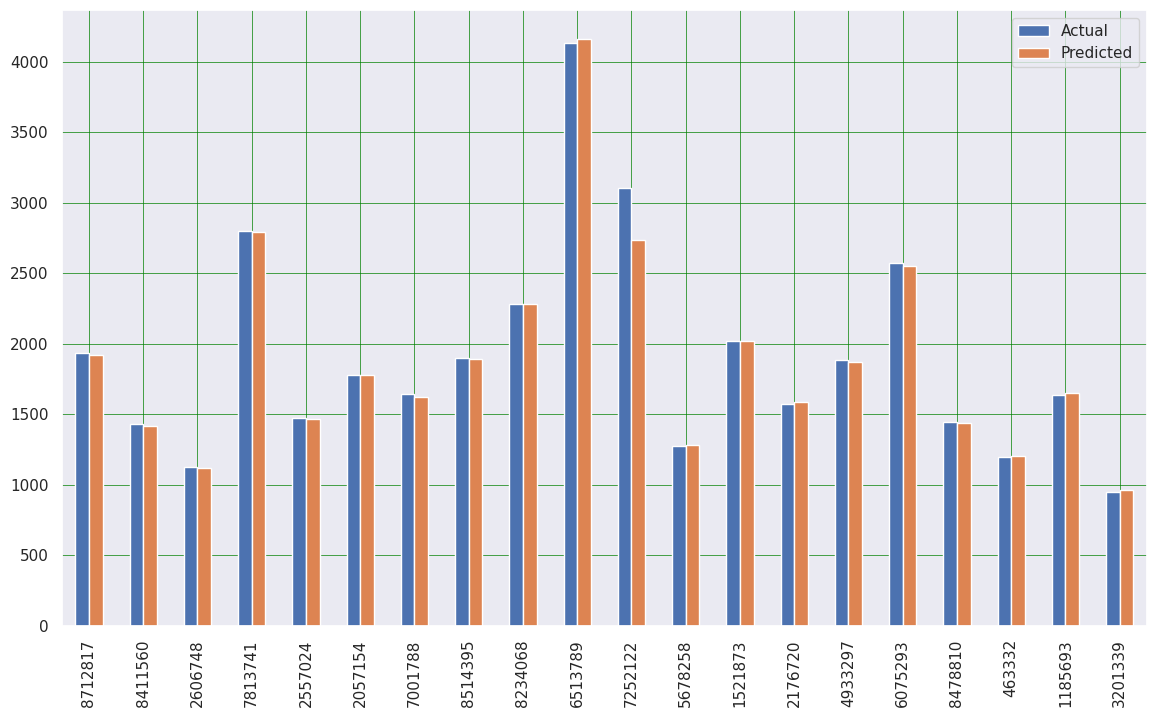

In [45]:
predictions.sample(20).plot(kind='bar',figsize=(14,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [46]:
xgb_score = r2_score(y_test, trips)
print(xgb_score)

0.973771737934757


In [ ]:
r2 = [lm_score, dt_score, rf_score, ad_score, gd_score, xgb_score]
tm = [lm_time, dt_time, rf_time, ad_time, gd_time, xgb_time]
comp = pd.DataFrame({'Time': tm, 'Accu': r2})

In [ ]:
label = ['LM', 'DT', 'RF', 'ADB', 'GDB', 'XGB']
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = comp['Time'].plot(kind='bar',title="Time",ax=axes[0],color = (1, 0.5, 0.13))
ax1 = comp['Accu'].plot(kind='bar',title="Accuarcy",ax=axes[1])
ax.set_ylabel("Time (secs)")
ax.set_xlabel('Models')
ax.set_xticklabels(label)
ax1.set_ylabel("Accuracy")
ax1.set_xlabel('Models')
ax1.set_xticklabels(label)
fig.tight_layout()